In [2]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
import imageio.v3 as iio

import warnings
warnings.filterwarnings('ignore')   

plt.style.use('paper.mplstyle')

In [3]:
# Define the colourmap
cmap1 = plt.cm.binary(np.linspace(0., 1, 64))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 128))
cmaplist = np.vstack((cmap1, cmap2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap.set_under(cmap(0))
cmap.set_bad(color=cmap(0))

In [4]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

file_mus = '%s/data_hstha/ngc1566/muse/NGC1566-0.80asec_MAPS.fits' %root_dir 
file_hst = '%s/data_hstha/ngc1566/hst_contsub/ngc1566_hst_ha_sic.fits' %root_dir 
file_hstcat = '%s/data_hstha_nebulae_catalogue/ngc1566/catalogue/ngc1566_mask.fits' %root_dir 
file_muscat = '%s/data_hstha/ngc1566/muse/NGC1566_nebmask.fits' %root_dir 

# Roated the JWST image to match the orientation of the MUSE and HST images
# sips -r 5.5 --padColor FFFFFF STScI-01HNGA39FNN541ZAF484AMYSDR.png -o jwst_hst_rotated.png
file_jwst = '%s/data_hstha/ngc1566/jwst/ngc1566_nircam_lv3_f300m_i2d_anchor.fits' %root_dir 
file_jwst_png = '%s/data_hstha/ngc1566/rgb/jwst_hst_rotated.png' %root_dir

hdu_mus = fits.open(file_mus)['HA6562_FLUX']
hdu_hst = fits.open(file_hst)[0]
hdu_hstcat = fits.open(file_hstcat)[0]
hdu_muscat = fits.open(file_muscat)[0]
hdu_jwst = fits.open(file_jwst)[1]

hdu_hstcat_masked = fits.open(file_hstcat)[0]
hdu_muscat_masked = fits.open(file_muscat)[0]

hdu_hstcat_masked.data = np.array(hdu_hstcat_masked.data, dtype=float)
hdu_muscat_masked.data = np.array(hdu_muscat_masked.data, dtype=float)

hdu_hstcat_masked.data[hdu_hstcat_masked.data==-1] = np.nan
hdu_muscat_masked.data[hdu_muscat_masked.data==-1] = np.nan

In [5]:
data_png = iio.imread(file_jwst_png)
data_png = data_png[:,:,2]
data_png = data_png[::-1]

data_jwst = hdu_jwst.data.copy()
hdr_jwst = hdu_jwst.header.copy()

print('Shape jwst %i %i' %data_jwst.shape)
print('Shape png %i %i' %data_png.shape)

print('CRVALS %f %f' %(hdr_jwst['CRVAL1'], hdr_jwst['CRVAL2']))
print('CRPIX %f %f' %(hdr_jwst['CRPIX1'], hdr_jwst['CRPIX2']))

crpix1 = (data_png.shape[1]/2)-31
crpix2 = (data_png.shape[0]/2)-195

hdr_jwst['CRPIX1'] = crpix1
hdr_jwst['CRPIX2'] = crpix2

hdu_hwst_new = fits.PrimaryHDU(data=data_png, header=hdr_jwst)
hdu_hwst_new.writeto('%s/data_hstha/ngc1566/jwst/tmp.fits' %root_dir, overwrite=True)

Shape jwst 4244 2531
Shape png 3648 2447
CRVALS 65.001647 -54.940314
CRPIX 1269.260011 2114.477800


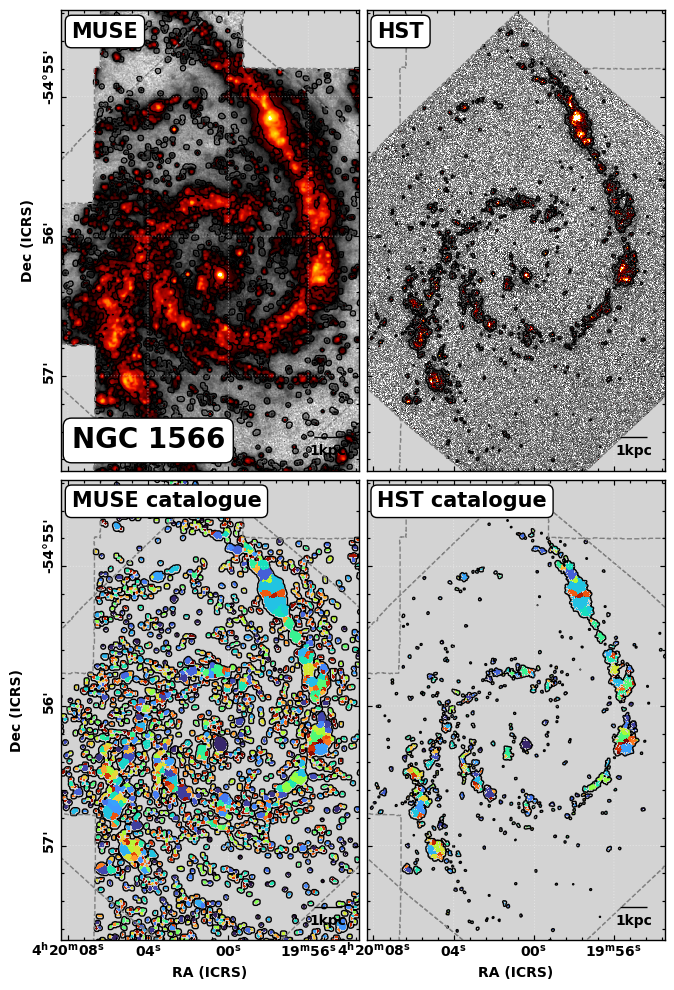

In [6]:
# Define the region
l = 65.0037553
b = -54.9338296
width = 0.0355611
height = 0.055

# Plot the maps
fig = plt.figure(figsize=(7, 10)) 

ax1 = aplpy.FITSFigure(hdu_mus, figure=fig, subplot=(2,2,1))
ax2 = aplpy.FITSFigure(hdu_hst, figure=fig, subplot=(2,2,2))
ax3 = aplpy.FITSFigure(hdu_muscat_masked, figure=fig, subplot=(2,2,3))
ax4 = aplpy.FITSFigure(hdu_hstcat_masked, figure=fig, subplot=(2,2,4))

vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.99])
vmin2, vmax2 = np.nanpercentile(hdu_hst.data, [10, 99.95])
vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
vmin4, vmax4 = np.nanpercentile(hdu_muscat.data, [0,100])

ax1.show_colorscale(cmap=cmap, stretch='log', vmin=vmin1, vmax=vmax1)
ax2.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin2, vmax=vmax2)
ax3.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin3, vmax=vmax3)
ax4.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin4, vmax=vmax4)

ax1.show_contour(hdu_muscat, levels=[0], colors='black', linewidths=1, smooth=1)
ax2.show_contour(hdu_hstcat, levels=[0], colors='black', linewidths=1, smooth=3)
ax3.show_contour(hdu_muscat, levels=[0], colors='black', linewidths=1, smooth=1)
ax4.show_contour(hdu_hstcat, levels=[0], colors='black', linewidths=1, smooth=3)

for ax in [ax1, ax2, ax3, ax4]:

    hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_mus.data)*1, hdu_mus.header)
    ax.show_contour(hdu_mask, levels=[0], colors='grey', linewidths=1, linestyles='--')

    hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_hst.data)*1, hdu_hst.header)
    ax.show_contour(hdu_mask, levels=[0], colors='grey', linewidths=1, linestyles='--')

    ax.recenter(l, b, width=width, height=height)

ax1.axis_labels.hide_x()
ax1.tick_labels.hide_x()
ax2.axis_labels.hide_x()
ax2.tick_labels.hide_x()
ax2.axis_labels.hide_y()
ax2.tick_labels.hide_y()
ax4.axis_labels.hide_y()
ax4.tick_labels.hide_y()

ax1.add_label(0.035, 0.035, 'NGC 1566', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=20, ha='left', va='bottom')
ax1.add_label(0.035, 0.975, 'MUSE', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
ax2.add_label(0.035, 0.975, 'HST', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
ax3.add_label(0.035, 0.975, 'MUSE catalogue', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
ax4.add_label(0.035, 0.975, 'HST catalogue', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')

for ax in [ax1, ax2, ax3, ax4]:

    ax.set_nan_color('lightgrey')
    ax.ticks.set_color('black')

    ax.add_scalebar(1000/(17.7e6/206265)*u.arcsec, corner='bottom right')
    ax.scalebar.set_label('1kpc')

for i, ax in enumerate(fig.get_axes()):

    axes = fig.get_axes()
    ra_ = axes[i].coords[0]
    dec_ = axes[i].coords[1]
    dec_.ticklabels.set_rotation(90)
    axes[i].grid(True, alpha=0.35, ls=':', color='white')
    axes[i].set_facecolor('lightgrey')

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=-0.05, hspace=0.02)

plt.savefig('./figs/maps_hstmuse_ngc1566_masks.pdf', dpi=250, bbox_inches='tight', transparent=True)

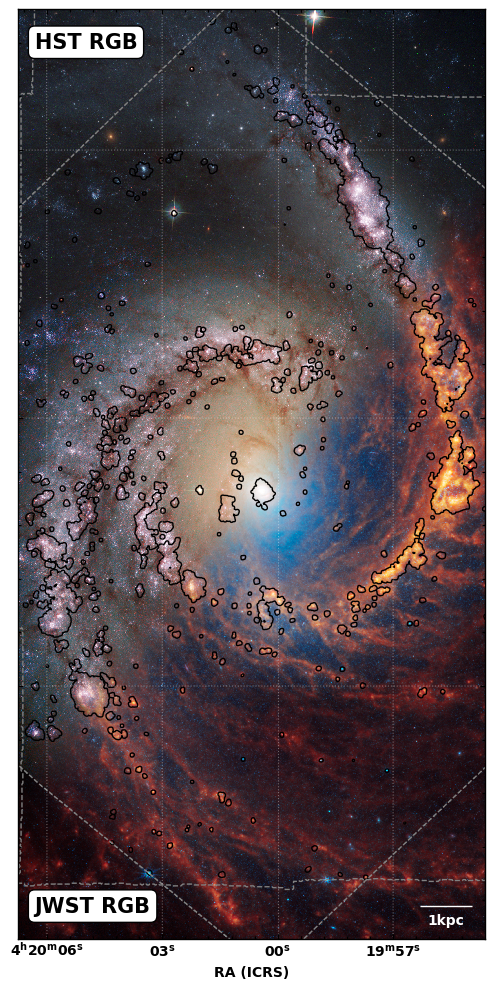

In [7]:
# # Define the region
# l = 65.0037553
# b = -54.9338296
# width = 0.03
# height = 0.055

# Define the region
l = 65.0028456
b = -54.9368264
width = 0.0289955
height = 0.0578610

# Plot the maps
fig = plt.figure(figsize=(10, 10)) 

ax1 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(1,1,1))
ax1.show_rgb(file_jwst_png)

ax1.show_contour(hdu_hstcat, levels=[0], colors='black', linewidths=1, smooth=3)

for ax in [ax1]:

    hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_mus.data)*1, hdu_mus.header)
    ax.show_contour(hdu_mask, levels=[0], colors='grey', linewidths=1, linestyles='--')

    hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_hst.data)*1, hdu_hst.header)
    ax.show_contour(hdu_mask, levels=[0], colors='grey', linewidths=1, linestyles='--')

    ax.recenter(l, b, width=width, height=height)

ax1.axis_labels.hide_y()
ax1.tick_labels.hide_y()

ax1.add_label(0.035, 0.975, 'HST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
ax1.add_label(0.035, 0.025, 'JWST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='bottom')

ax1.set_nan_color('lightgrey')
ax1.ticks.set_color('black')
ax1.add_scalebar(1000/(17.7e6/206265)*u.arcsec, corner='bottom right', color='white')
ax1.scalebar.set_label('1kpc')

for i, ax in enumerate(fig.get_axes()):

    axes = fig.get_axes()
    ra_ = axes[i].coords[0]
    dec_ = axes[i].coords[1]
    dec_.ticklabels.set_rotation(90)
    axes[i].grid(True, alpha=0.35, ls=':', color='white')
    axes[i].set_facecolor('lightgrey')

fig.tight_layout(h_pad=0, w_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig('./figs/maps_hstmuse_ngc1566_masks_jwsthst.pdf', dpi=150, bbox_inches='tight', transparent=True)

In [8]:
# # Plot the maps
# fig = plt.figure(figsize=(10, 9)) 

# ax1 = aplpy.FITSFigure(hdu_mus, figure=fig, subplot=(2,3,1))
# ax2 = aplpy.FITSFigure(hdu_hst, figure=fig, subplot=(2,3,2))
# ax3 = aplpy.FITSFigure(hdu_muscat_masked, figure=fig, subplot=(2,3,4))
# ax4 = aplpy.FITSFigure(hdu_hstcat_masked, figure=fig, subplot=(2,3,5))
# ax5 = aplpy.FITSFigure(hdu_hst_cont, figure=fig, subplot=(2,3,3))
# ax6 = aplpy.FITSFigure(hdu_jwst, figure=fig, subplot=(2,3,6))

# vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.99])
# vmin2, vmax2 = np.nanpercentile(hdu_hst.data, [10, 99.95])
# vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
# vmin4, vmax4 = np.nanpercentile(hdu_muscat.data, [0,100])
# vmin5, vmax5 = np.nanpercentile(hdu_hst_cont.data, [0, 99.99])
# vmin6, vmax6 = np.nanpercentile(hdu_jwst.data, [0,100])

# ax1.show_colorscale(cmap=cmap, stretch='log', vmin=vmin1, vmax=vmax1)
# ax2.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin2, vmax=vmax2)
# ax3.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin3, vmax=vmax3)
# ax4.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin4, vmax=vmax4)
# ax5.show_colorscale(cmap='magma', stretch='sqrt', vmin=vmin5, vmax=vmax5)
# ax6.show_rgb(file_jwst_png)


# ax1.show_contour(hdu_muscat, levels=[0], colors='white', linewidths=1, smooth=1)
# ax2.show_contour(hdu_hstcat, levels=[0], colors='white', linewidths=1, smooth=3)
# ax3.show_contour(hdu_muscat, levels=[0], colors='white', linewidths=1, smooth=1)
# ax4.show_contour(hdu_hstcat, levels=[0], colors='white', linewidths=1, smooth=3)
# ax5.show_contour(hdu_hstcat, levels=[0], colors='white', linewidths=1, smooth=3)
# ax6.show_contour(hdu_hstcat, levels=[0], colors='white', linewidths=1, smooth=3)


# for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:

#     hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_mus.data)*1, hdu_mus.header)
#     ax.show_contour(hdu_mask, levels=[0], colors='black', linewidths=1, linestyles='--')

#     hdu_mask = fits.PrimaryHDU(~np.isnan(hdu_hst.data)*1, hdu_hst.header)
#     ax.show_contour(hdu_mask, levels=[0], colors='black', linewidths=1, linestyles='--')

#     ax.recenter(l, b, width=width, height=height)

# ax1.axis_labels.hide_x()
# ax1.tick_labels.hide_x()
# ax2.axis_labels.hide_x()
# ax2.tick_labels.hide_x()
# ax5.axis_labels.hide_x()
# ax5.tick_labels.hide_x()

# ax2.axis_labels.hide_y()
# ax2.tick_labels.hide_y()
# ax4.axis_labels.hide_y()
# ax4.tick_labels.hide_y()
# ax5.axis_labels.hide_y()
# ax5.tick_labels.hide_y()
# ax6.axis_labels.hide_y()
# ax6.tick_labels.hide_y()

# ax1.add_label(0.035, 0.035, 'NGC 4303', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=20, ha='left', va='bottom')
# ax1.add_label(0.035, 0.975, 'MUSE', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
# ax2.add_label(0.035, 0.975, 'HST', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
# ax3.add_label(0.035, 0.975, 'MUSE catalogue', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')
# ax4.add_label(0.035, 0.975, 'HST catalogue', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=15, ha='left', va='top')

# for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:

#     ax.set_nan_color('lightgrey')
#     ax.ticks.set_color('black')

#     ax.add_scalebar(500/(5.2e6/206265)*u.arcsec, corner='bottom right')
#     ax.scalebar.set_label('500pc')

# for i, ax in enumerate(fig.get_axes()):

#     axes = fig.get_axes()
#     ra_ = axes[i].coords[0]
#     dec_ = axes[i].coords[1]
#     dec_.ticklabels.set_rotation(90)
#     axes[i].grid(True, alpha=0.35, ls=':', color='white')
#     axes[i].set_facecolor('lightgrey')

# fig.tight_layout(h_pad=0.1, w_pad=0.1)
# fig.subplots_adjust(wspace=0.01, hspace=0.01)

# plt.savefig('./figs/maps_hstmuse_ngc1566_masks_jwsthst.pdf', dpi=250, bbox_inches='tight', transparent=True)